In [1]:
import os
os.listdir('../input/amex-default-prediction')

['sample_submission.csv',
 'train_data.csv',
 'test_data.csv',
 'train_labels.csv']

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gc

df_train = pd.read_parquet("../input/train-test-parquet/train.parquet")
df_train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")

print(len(df_train))
print(df_train.shape)

5531451
(5531451, 190)


In [3]:
# Get only the latest transaction of each customer_ID
df_train = df_train.groupby('customer_ID').tail(1)
print(df_train)

                                               customer_ID         S_2  \
12       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-03-13   
25       00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2018-03-25   
38       00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  2018-03-12   
51       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2018-03-29   
64       00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...  2018-03-30   
...                                                    ...         ...   
5531398  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-03-31   
5531411  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2018-03-22   
5531424  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-03-07   
5531437  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2018-03-23   
5531450  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-03-14   

              P_2  D_39       B_1       B_2       R_1       S_3  D_41  \
12       0.934745     0  0.009382  1.0

In [4]:
df_train = df_train.drop(df_train.columns[df_train.apply(lambda col: (col.isnull() | col.isna()).mean().round(5)*100 >= 50)], axis=1)
print(df_train)

                                               customer_ID         S_2  \
12       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2018-03-13   
25       00000fd6641609c6ece5454664794f0340ad84dddce9a2...  2018-03-25   
38       00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  2018-03-12   
51       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2018-03-29   
64       00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...  2018-03-30   
...                                                    ...         ...   
5531398  ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...  2018-03-31   
5531411  ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...  2018-03-22   
5531424  ffff9984b999fccb2b6127635ed0736dda94e544e67e02...  2018-03-07   
5531437  ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...  2018-03-23   
5531450  fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...  2018-03-14   

              P_2  D_39       B_1       B_2       R_1       S_3  D_41  \
12       0.934745     0  0.009382  1.0

In [5]:
df_train = pd.merge(df_train, df_train_labels, on='customer_ID' )

In [6]:
cat_var = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'target']
df_train[cat_var] = df_train[cat_var].fillna(0)

print(df_train[cat_var].dtypes)
df_train[['D_63','D_64']] = df_train[['D_63','D_64']].astype('category').apply(lambda x: x.cat.codes)
print(df_train[cat_var].dtypes)

B_30       int8
B_38       int8
D_114      int8
D_116      int8
D_117      int8
D_120      int8
D_126      int8
D_63       int8
D_64       int8
D_66       int8
D_68       int8
target    int64
dtype: object
B_30       int8
B_38       int8
D_114      int8
D_116      int8
D_117      int8
D_120      int8
D_126      int8
D_63       int8
D_64       int8
D_66       int8
D_68       int8
target    int64
dtype: object


In [7]:
df_train.isnull().all().sum() # check if entries of all rows are empty

0

In [8]:
df_train.set_index('customer_ID')

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,...,-1,-1,-1,0,0,0.000000,0,0.002970,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.060646,...,-1,-1,-1,0,0,0.000000,0,0.003169,0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-03-12,0.880875,0,0.004284,0.812649,0.006450,NaN,0.0,0.007196,NaN,...,-1,-1,-1,0,0,0.000000,0,0.000834,0,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,2018-03-29,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,0.046104,...,-1,-1,-1,0,0,0.000000,0,0.005560,0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,2018-03-30,0.871900,0,0.007679,0.815746,0.001247,NaN,0.0,0.005528,0.044671,...,-1,-1,-1,0,0,0.000000,0,0.006944,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,2018-03-31,0.844229,15,0.028515,1.009866,0.001928,0.128707,0.0,0.005893,0.113053,...,-1,-1,-1,0,0,0.000000,0,0.003009,0,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,2018-03-22,0.831279,1,0.292360,0.055656,0.006953,NaN,0.0,0.233078,0.134540,...,-1,-1,-1,0,0,0.000000,0,0.009230,0,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,2018-03-07,0.800522,9,0.020563,1.007023,0.000957,0.066648,0.0,0.006314,0.049778,...,-1,-1,-1,0,0,0.000000,0,0.000340,0,0


In [9]:
# Remove redundant variables: customer_ID and S_2 (date).
df_train.drop(df_train.iloc[:,0:2], axis=1, inplace=True)
df_train = df_train.apply(abs)

In [10]:
del df_train_labels
gc.collect()

21

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types

# Subsample 10% of dataset to reduce time at an expense of performance to ensure ML model runs efficiently fast.
df_train_sample = df_train.copy().sample(frac=0.05)
# Pipe-line preprocessing for numerical and categorical features to prevent error in codes and leaking of data during training:
features = df_train_sample.drop('target', axis=1).columns
X = df_train_sample[features].copy()
y = df_train_sample['target'].copy()

print(df_train_sample)

             P_2  D_39       B_1       B_2       R_1       S_3      D_41  \
414397  0.342541     1  0.304075  0.036156  0.007708  0.149161  0.000000   
25933   0.475531     1  0.044681  0.280884  0.003263  0.172947  0.000000   
386595  0.883447     0  0.003064  0.811388  0.002584       NaN  0.000000   
203484  0.332998     0  0.220517  0.321077  0.008993  0.170261  0.000000   
106681  0.531445     0  0.002420  0.813535  0.003919  0.210851  0.000000   
...          ...   ...       ...       ...       ...       ...       ...   
199837  0.323826     0  0.109405  0.030853  0.502450  0.380274  0.000000   
191794  0.195937     1  0.182035  0.022300  1.001030  0.221117  0.227226   
256127  0.547931    14  0.272481  0.019739  0.006619  0.177033  0.000000   
199797  0.977161     0  0.003033  0.813945  0.009420  0.354991  0.000000   
270088  0.379574    17  0.099010  0.155661  0.506191  0.278663  0.788212   

             B_3      D_43  D_44  ...  D_136  D_137  D_138  D_139  D_140  \
414397  0.2

In [12]:
categorical_features = [ 'B_30','B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [13]:
numerical_features = [x for x in features if x not in categorical_features]
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])


In [14]:
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)], 
        remainder='passthrough') 

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV   
# Train-test validation approach.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [16]:
del df_train, df_train_sample, features
gc.collect()

105

In [17]:
# Set parameters for imputer on numerical and categorical features.
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'] ,
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}


In [18]:
# RandomForest Model
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
pipe_catboost = Pipeline(steps=[('data_transformer', data_transformer),
                     ('pipe_catboost', CatBoostClassifier(iterations=1000,
                        task_type="GPU", random_state=1))])  # ,

grid_catboost = GridSearchCV(pipe_catboost, param_grid=param_grid) # , cv=10
grid_catboost.fit(X_train, y_train.values); 

print(grid_catboost.best_score_) 
print(grid_catboost.best_params_)
print(grid_catboost.best_estimator_)

Learning rate set to 0.029294
0:	learn: 0.6605816	total: 48.1ms	remaining: 48s
1:	learn: 0.6283249	total: 137ms	remaining: 1m 8s
2:	learn: 0.5983819	total: 223ms	remaining: 1m 13s
3:	learn: 0.5725928	total: 272ms	remaining: 1m 7s
4:	learn: 0.5474448	total: 341ms	remaining: 1m 7s
5:	learn: 0.5248501	total: 427ms	remaining: 1m 10s
6:	learn: 0.5033035	total: 504ms	remaining: 1m 11s
7:	learn: 0.4829452	total: 584ms	remaining: 1m 12s
8:	learn: 0.4664866	total: 629ms	remaining: 1m 9s
9:	learn: 0.4540344	total: 670ms	remaining: 1m 6s
10:	learn: 0.4405176	total: 710ms	remaining: 1m 3s
11:	learn: 0.4274107	total: 764ms	remaining: 1m 2s
12:	learn: 0.4177116	total: 812ms	remaining: 1m 1s
13:	learn: 0.4049499	total: 851ms	remaining: 59.9s
14:	learn: 0.3941371	total: 890ms	remaining: 58.5s
15:	learn: 0.3842509	total: 929ms	remaining: 57.2s
16:	learn: 0.3750562	total: 969ms	remaining: 56s
17:	learn: 0.3673061	total: 1.01s	remaining: 55s
18:	learn: 0.3594309	total: 1.05s	remaining: 54.2s
19:	learn: 0

In [19]:
gc.collect()

309

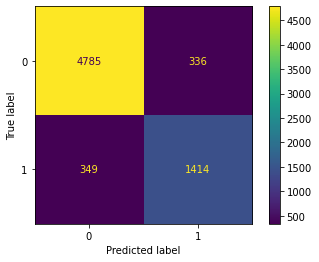

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

y_pred_catboost = grid_catboost.predict(X_test)
y_pred_prob_catboost = grid_catboost.predict_proba(X_test)
cm_catboost = confusion_matrix(y_test, y_pred_catboost, labels= grid_catboost.classes_)

disp_catboost = ConfusionMatrixDisplay(confusion_matrix=cm_catboost)
disp_catboost.plot()
plt.show()

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(classification_report(y_test, y_pred_catboost))
print('accuracy score:', accuracy_score(y_test, y_pred_catboost)) # overall accuracy score: true positive+true negative/total observations
print('recall score:', recall_score(y_test, y_pred_catboost, average=None)) # recall score for passenger that survives is not very good, recommend to adjust threshold to get better and balanced score.
print('precision score:', precision_score(y_test, y_pred_catboost, average=None))
print('f1 score:', f1_score(y_test, y_pred_catboost, average=None))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5121
           1       0.81      0.80      0.81      1763

    accuracy                           0.90      6884
   macro avg       0.87      0.87      0.87      6884
weighted avg       0.90      0.90      0.90      6884

accuracy score: 0.9004938988959907
recall score: [0.93438781 0.80204197]
precision score: [0.93202182 0.808     ]
f1 score: [0.93320332 0.80500996]


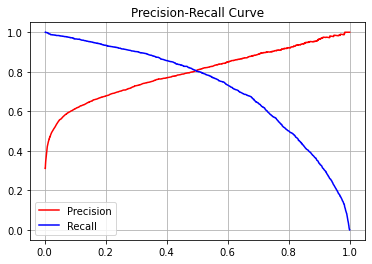

In [22]:
precision, recall, threshold = precision_recall_curve(y_test.astype(int), grid_catboost.predict_proba(X_test)[:,1])

plt.plot(threshold, precision[:-1], c='r', label='Precision')
plt.plot(threshold, recall[:-1], c='b', label='Recall')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


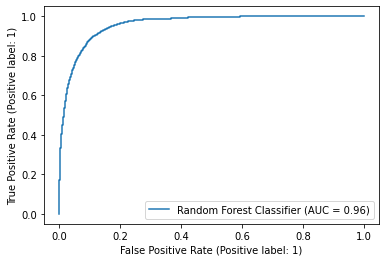

roc auc score: 0.9587610013509706


In [23]:
from sklearn.metrics import roc_curve, plot_roc_curve

ax = plt.gca()  # get current Axes instance
plot_roc_curve(grid_catboost, X_test, y_test, ax=ax, name='Random Forest Classifier')
plt.show()

print('roc auc score:', roc_auc_score(y_test, grid_catboost.predict_proba(X_test)[:,1]))

In [24]:
del X_train, y_train , X_test, y_test
gc.collect()

3433

In [25]:
# Pre-process test dataset too
df_submission = pd.read_csv("../input/amex-default-prediction/sample_submission.csv", usecols=['customer_ID'], low_memory=True)
df_test = pd.read_parquet('../input/train-test-parquet/test.parquet')
print(len(df_submission))
print(len(df_test))

924621
11363762


In [26]:
df_test = df_test.groupby('customer_ID').tail(1)
print(df_test)

                                                customer_ID         S_2  \
8         00000469ba478561f23a92a868bd366de6f6527a684c9a...  2019-10-12   
21        00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...  2019-04-15   
34        0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...  2019-10-16   
47        00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...  2019-04-22   
60        00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...  2019-10-22   
...                                                     ...         ...   
11363714  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...  2019-04-14   
11363727  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...  2019-10-19   
11363740  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...  2019-04-06   
11363753  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...  2019-04-08   
11363761  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...  2019-04-18   

               P_2  D_39       B_1       B_2       R_1       S_3      D_41  \
8         0.568930   

In [27]:
df_test.drop(df_test.iloc[:,0:2], axis=1, inplace=True)
df_test[['D_63','D_64']] = df_test[['D_63','D_64']].astype('category').apply(lambda x: x.cat.codes)
df_test = df_test.apply(abs)

#df_test = df_test.drop(df_test.columns[df_test.apply(lambda col: ((col.isnull() | col.isna()).mean().round(5)*100) >= 50)], axis=1)
cat_test_var = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
df_test[cat_test_var] = df_test[cat_test_var].fillna(0)

print(df_test)
print(df_test.dtypes)

               P_2  D_39       B_1       B_2       R_1       S_3      D_41  \
8         0.568930     4  0.010779  1.009347  0.000000  0.149413  0.000000   
21        0.841177     4  0.016562  1.009245  0.000000  0.112195  0.000000   
34        0.697522     0  0.001484  0.810072  0.000000  0.166165  0.000000   
47        0.513186    11  0.149511  0.205678  0.000000  0.181200  0.000000   
60        0.254478    26  0.563603  0.038021  0.503154  0.168317  0.000000   
...            ...   ...       ...       ...       ...       ...       ...   
11363714  0.646915     0  0.011309  0.817037  0.000000  0.162921  0.000000   
11363727  0.471303     0  0.084163  0.082507  0.508855  0.857136  0.000000   
11363740  0.206425     0  0.019952  1.004201  0.000000  0.321134  0.077758   
11363753  0.570670     1  0.049776  0.192895  0.000000  0.230847  0.000000   
11363761  0.454546     0  0.000346  0.810128  0.000000       NaN  0.000000   

               B_3      D_42      D_43  ...  D_136  D_137  D_13

In [28]:
# Check if columns are removed correctly based on number of columns with more than 50% of NAs
count_nulls = (df_test.isnull() | df_test.isna()).mean().round(5)*100
count_nulls = count_nulls.drop(count_nulls[count_nulls >= 50].index)
print(count_nulls)

P_2      0.517
D_39     0.000
B_1      0.000
B_2      0.005
R_1      0.000
         ...  
D_140    0.000
D_141    0.546
D_143    0.000
D_144    0.000
D_145    0.000
Length: 172, dtype: float64


In [29]:
df_test.isnull().all(axis=1)
gc.collect()

42

In [30]:
# Predict on test data set
test_pred_rfc = grid_catboost.predict(df_test)
test_pred_prob_catboost = grid_catboost.predict_proba(df_test)
print(len(test_pred_prob_catboost))
print(test_pred_prob_catboost)
print(test_pred_prob_catboost[:,1])

924621
[[0.98855646 0.01144354]
 [0.99823765 0.00176235]
 [0.97756095 0.02243905]
 ...
 [0.48340236 0.51659764]
 [0.57634407 0.42365593]
 [0.92613686 0.07386314]]
[0.01144354 0.00176235 0.02243905 ... 0.51659764 0.42365593 0.07386314]


In [31]:
df_test['prediction'] = None
df_test['prediction'] = test_pred_prob_catboost[:,1]

In [32]:
submission = pd.DataFrame({'customer_ID': df_submission.customer_ID, 'prediction': test_pred_prob_catboost[:,1]})
submission.to_csv('submission.csv', index=False)
print(submission)

                                              customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...    0.011444
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...    0.001762
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...    0.022439
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...    0.247083
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    0.877761
...                                                   ...         ...
924616  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...    0.017493
924617  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...    0.858510
924618  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...    0.516598
924619  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...    0.423656
924620  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...    0.073863

[924621 rows x 2 columns]


In [33]:
submission = pd.read_csv('./submission.csv')
print(submission)

                                              customer_ID  prediction
0       00000469ba478561f23a92a868bd366de6f6527a684c9a...    0.011444
1       00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...    0.001762
2       0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...    0.022439
3       00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...    0.247083
4       00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    0.877761
...                                                   ...         ...
924616  ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...    0.017493
924617  ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...    0.858510
924618  ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...    0.516598
924619  ffffddef1fc3643ea179c93245b68dca0f36941cd83977...    0.423656
924620  fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...    0.073863

[924621 rows x 2 columns]
